# 7章 畳み込みニューラルネット

畳み込みニューラルネット - convolutional neural network - CNN  
CNNの場合、Convolutionレイヤ(畳み込み層)とPoolingレイヤ(プーリング層)がある  
前の章でやったのは

Affine -> ReLU -> Affine -> ReLU -> ... -> Affine ->Softmax  

CNNの場合は  

Conv -> ReLU -> Pooling -> ... -> Conv -> ReLU -> Affine -> Softmax  

みたいな感じ  

### 全結合層の問題点

データの形状が無視される  
mninstで3次元データを1次元に丸めてた  
畳み込み層(Convolutionレイヤ)は形状を維持する  
CNNでは畳み込み層の入出力データを特徴Mapということがある  


In [6]:

def output_size(input_size, filter_size, padding, stride):
    h, w = input_size
    fh, fw = filter_size
    oh = (h + 2 * padding - fh) / stride + 1
    ow = (w + 2 * padding - fw) / stride + 1
    return (oh, ow)

print(output_size((4, 4), (3,3), 1, 1))
print(output_size((7, 7), (3,3), 0, 2))

(4.0, 4.0)
(3.0, 3.0)


チャンネル数: RGBのあれ, RGBだけの場合チャンネル数は3  
プーリング層は学習パラメータがない  
MaxプーリングやAverageプーリングがある  
画像認識の分野では主にMaxプーリングが使われるらしい  


In [9]:
import numpy as np

x = np.random.rand(10, 1, 28, 28)
x[0, 0]

array([[  2.21733451e-02,   9.69125868e-01,   9.21443314e-01,
          7.81370800e-01,   8.19578958e-01,   8.73035980e-01,
          5.30688238e-01,   1.74036670e-01,   5.30367258e-01,
          3.01593650e-01,   6.61225126e-01,   2.53963994e-01,
          5.53413037e-01,   5.94816741e-01,   8.49960518e-01,
          6.18121618e-02,   3.10448222e-01,   3.23551236e-01,
          1.52966292e-01,   8.81483556e-01,   3.19533872e-01,
          8.56654526e-01,   2.97893165e-01,   8.57048580e-02,
          9.14108568e-01,   6.88910294e-01,   2.19467410e-01,
          5.08738612e-01],
       [  7.68134371e-01,   8.14692920e-02,   1.17164186e-01,
          9.84347596e-01,   6.15567949e-01,   5.45806099e-01,
          3.54649790e-01,   9.17523704e-01,   1.04679676e-01,
          5.62955051e-01,   9.29417189e-01,   6.08802294e-02,
          4.09521712e-01,   7.93762705e-01,   3.88987804e-01,
          6.76039032e-01,   7.49841056e-01,   1.51354971e-01,
          8.22463972e-01,   8.86997620e-01,

In [11]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col
import numpy as np

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1)
print(col1.shape) # (9, 75)
x2 = np.random.rand(10, 3, 7, 7) # 10 個のデータ 
col2 = im2col(x2, 5, 5, stride=1, pad=0) 
print(col2)
print(col2.shape) # (90, 75)

[[ 0.08200649  0.60281809  0.60957024  0.50482506  0.86048201  0.76671859
   0.4987823   0.82740731  0.57641981  0.32262226  0.84695473  0.48043815
   0.53257602  0.92100921  0.58847885  0.1095169   0.7527334   0.53630375
   0.67068655  0.54831719  0.23068597  0.22722243  0.70044057  0.3642506
   0.82246315  0.20856567  0.60973664  0.56457191  0.42264584  0.34516558
   0.03628955  0.14923779  0.60392934  0.93156192  0.68356851  0.3946918
   0.20367617  0.51275619  0.27974343  0.41472465  0.6428923   0.20051586
   0.1829886   0.51024102  0.37143785  0.67592319  0.85170955  0.12859554
   0.21229038  0.72046335  0.49640553  0.29414986  0.0878488   0.90716957
   0.88924189  0.29649341  0.85424094  0.56274566  0.57399482  0.15858513
   0.4051926   0.77726386  0.33251176  0.21524041  0.79867807  0.04889734
   0.85020508  0.99185659  0.04059558  0.52476432  0.95583689  0.55915492
   0.30432084  0.80281842  0.59083081]
 [ 0.60281809  0.60957024  0.50482506  0.86048201  0.42263087  0.4987823
  

In [12]:
class Convolution:
    def __init__(self, W, b, stride = 1, pad = 0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        return out

    
# Poolingレイヤのbackward処理はReLUレイヤの実装で使ったmaxの逆伝播(5.5.1)が参考になるらしい
# 実装はcommon/layer.pyにある

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self/stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        out = np.max(col, axis = 1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3,1,2)
        return out
    


In [13]:
from collections import OrderedDict

class SimpleConvNet:
    def __init__(self, input_dim = (1,28,28),
                 conv_param = {'filter_num': 30, 'filter_size': 5,
                              'pad':0, 'stride':1},
                 hidden_size = 100, output_size =10, weight_init_std=0.01
                ):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['filter_pad']
        filter_stride = conv_param['fiter_stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def gradient(self, x, t):
        self.loss(x, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        return grads
        

train loss:2.29995003306
=== epoch:1, train acc:0.286, test acc:0.278 ===
train loss:2.29906235163
train loss:2.29426167373
train loss:2.28952462177
train loss:2.28309055267
train loss:2.27281134902
train loss:2.27114245764
train loss:2.24699509357
train loss:2.24227652638
train loss:2.21983742922
train loss:2.1835868888
train loss:2.14371549693
train loss:2.11638414965
train loss:2.05407661001
train loss:2.0389507229
train loss:2.02829945076
train loss:1.9411216265
train loss:1.83065424194
train loss:1.75304960505
train loss:1.7177022906
train loss:1.66308472443
train loss:1.51349695084
train loss:1.46855829259
train loss:1.45046279037
train loss:1.38145277293
train loss:1.24682437399
train loss:1.22991111143
train loss:1.00082384635
train loss:1.03375610652
train loss:1.03040354216
train loss:0.949880491664
train loss:1.00788266528
train loss:0.857092846452
train loss:0.867244712783
train loss:0.735053795436
train loss:0.838987999717
train loss:0.738569355041
train loss:0.72033532987

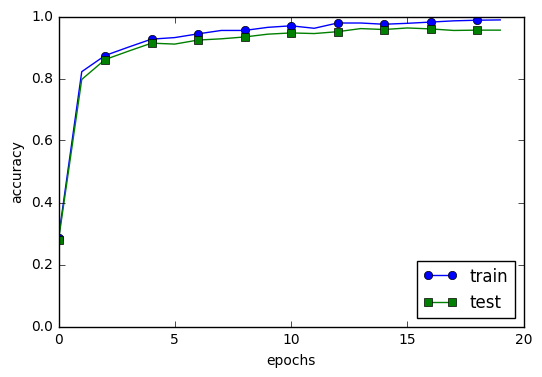

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from ch7.simple_convnet import SimpleConvNet
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


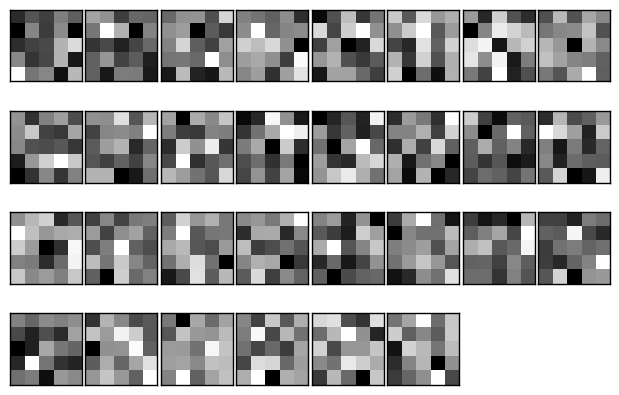

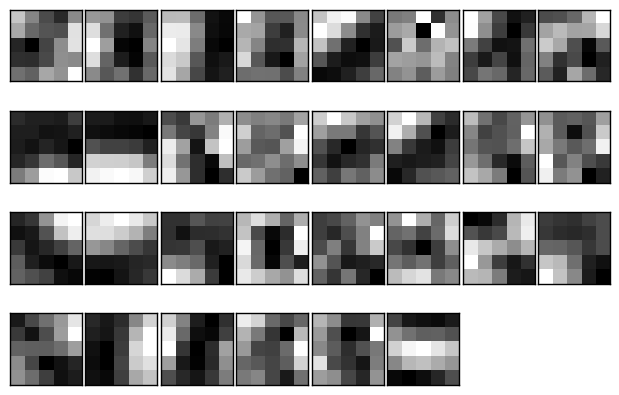

In [6]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from ch7.simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])